In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
import tensorflow as tf

In [3]:
# Load the data from the Excel file
file_path = r"C:\Users\navab\Downloads\Magnificient_7_same_base_data.xlsx"

In [5]:
# Read the Excel file into a DataFrame, replacing 'N/A N/A' with 0
data = pd.read_excel(file_path, na_values=['#N/A N/A'])

In [7]:
# Fill any remaining NaN values with 0
data.fillna(0, inplace=True)

In [9]:
data.head()

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_CLOSE_1D,BLOOMBERG_CLOSE_PRICE,PX_VOLUME,PX_LAST
0,2012-05-18,19.070,19.408,18.881,18.933,0.0,732287052,18.942
1,2012-05-21,19.089,20.055,19.073,18.942,0.0,631091160,20.046
2,2012-05-22,20.341,20.496,19.735,20.046,0.0,694787016,19.892
3,2012-05-23,19.911,20.457,19.758,19.892,0.0,584897460,20.377
4,2012-05-24,20.567,20.589,20.044,20.377,0.0,496198024,20.190


In [11]:
# Convert the 'Dates' column to datetime format
data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')

In [13]:
# Set the 'Dates' column as the index
data.set_index('Dates', inplace=True)

In [15]:
# Extract the relevant columns
data = data[['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_CLOSE_1D', 'BLOOMBERG_CLOSE_PRICE', 'PX_VOLUME', 'PX_LAST']]

In [17]:
data.head()

,PX_OPEN,PX_HIGH,PX_LOW,PX_CLOSE_1D,BLOOMBERG_CLOSE_PRICE,PX_VOLUME,PX_LAST
Dates,,,,,,,
2012-05-18,19.070,19.408,18.881,18.933,0.0,732287052,18.942
2012-05-21,19.089,20.055,19.073,18.942,0.0,631091160,20.046
2012-05-22,20.341,20.496,19.735,20.046,0.0,694787016,19.892
2012-05-23,19.911,20.457,19.758,19.892,0.0,584897460,20.377
2012-05-24,20.567,20.589,20.044,20.377,0.0,496198024,20.190


In [19]:
data.tail()

,PX_OPEN,PX_HIGH,PX_LOW,PX_CLOSE_1D,BLOOMBERG_CLOSE_PRICE,PX_VOLUME,PX_LAST
Dates,,,,,,,
2024-07-24,224.00,224.80,217.13,225.01,218.54,61777576,218.54
2024-07-25,218.93,220.85,214.62,218.54,217.49,51391199,217.49
2024-07-26,218.70,219.49,216.01,217.49,217.96,41601345,217.96
2024-07-29,216.96,219.30,215.75,217.96,218.24,36311778,218.24
2024-07-30,0.00,0.00,0.00,218.24,0.00,262734,0.00


In [21]:
data.count()

PX_OPEN                  3068
PX_HIGH                  3068
PX_LOW                   3068
PX_CLOSE_1D              3068
BLOOMBERG_CLOSE_PRICE    3068
PX_VOLUME                3068
PX_LAST                  3068
dtype: int64

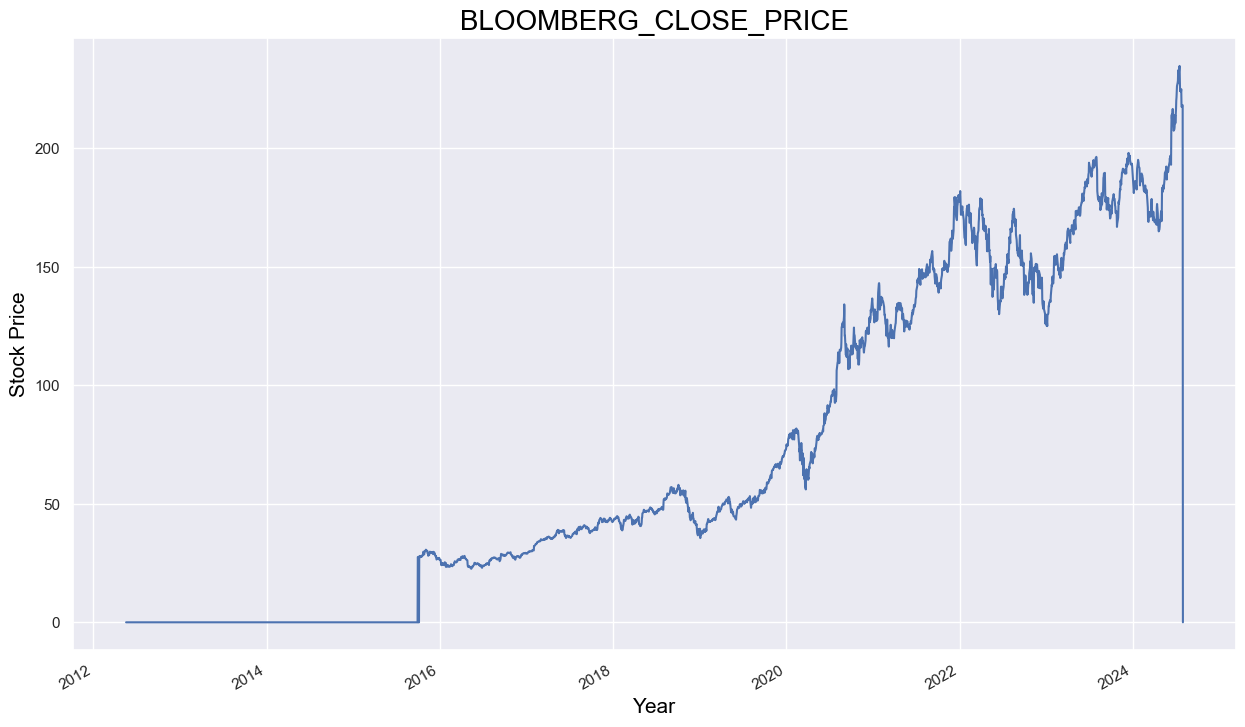

In [23]:
# Plot the BLOOMBERG_CLOSE_PRICE
sns.set(rc={'figure.figsize': (15, 9)})
data['BLOOMBERG_CLOSE_PRICE'].plot(grid=True)
plt.title('BLOOMBERG_CLOSE_PRICE', color='black', fontsize=20)
plt.xlabel('Year', color='black', fontsize=15)
plt.ylabel('Stock Price', color='black', fontsize=15)
plt.show()

In [61]:
# Standardize data for training the model
def ts_train_test(data, time_steps, for_periods):
    '''
    Create training and test sets, scale data

    :param data: DataFrame with dates and price data
    :param time_steps: number of input time steps
    :param for_periods: number of output time steps

    :returns: X_train, y_train: data from 2012-2016
              X_test:  data from 2017 onward
              sc: instantiated MinMaxScaler object fit to the training data
    '''
    # Create training and test set
    ts_train = data['2012':'2016'].iloc[:, 0:1].values
    ts_test = data['2017':].iloc[:, 0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Feature scaling
    sc = MinMaxScaler(feature_range=(0, 1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Create training data of samples and time steps
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len - for_periods + 1):
        X_train.append(ts_train_scaled[i - time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i + for_periods, 0])

    # Convert X_train and y_train to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape X_train to 3-D array
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Prepare to create X_test
    inputs = pd.concat((data["PX_CLOSE_1D"]['2012':'2016'], data["PX_CLOSE_1D"]['2017':]), axis=0).values
    inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    # Create X_test
    X_test = []
    for i in range(time_steps, len(ts_test) + time_steps - for_periods + 1):
        X_test.append(inputs[i - time_steps:i, 0])

    # Convert X_test to numpy array
    X_test = np.array(X_test)

    # Reshape X_test to 3-D
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, sc

X_train, y_train, X_test, sc = ts_train_test(data, 5, 2)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1157 samples in the training data
There are 1904 samples in the test data


In [63]:
X_train

array([[[0.26389311],
        [0.26485474],
        [0.32822148],
        [0.30645814],
        [0.33965988]],

       [[0.26485474],
        [0.32822148],
        [0.30645814],
        [0.33965988],
        [0.31926308]],

       [[0.32822148],
        [0.30645814],
        [0.33965988],
        [0.31926308],
        [0.33065088]],

       ...,

       [[0.76394372],
        [0.77583764],
        [0.77659682],
        [0.77092823],
        [0.76131187]],

       [[0.77583764],
        [0.77659682],
        [0.77092823],
        [0.76131187],
        [0.77305395]],

       [[0.77659682],
        [0.77092823],
        [0.76131187],
        [0.77305395],
        [0.78570706]]])

In [69]:
X_train.dtype

dtype('float64')

In [75]:
# Define the simple RNN model
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    Create RNN model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    '''
    # The RNN architecture
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    my_rnn_model.add(SimpleRNN(32))
    # The output layer
    my_rnn_model.add(Dense(2))  # The time step of the output is 2

    # Compile the RNN model
    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # Fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)

    # Make Predictions using the test set
    rnn_predictions = my_rnn_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test, sc)

C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


MSE score: 6637.487


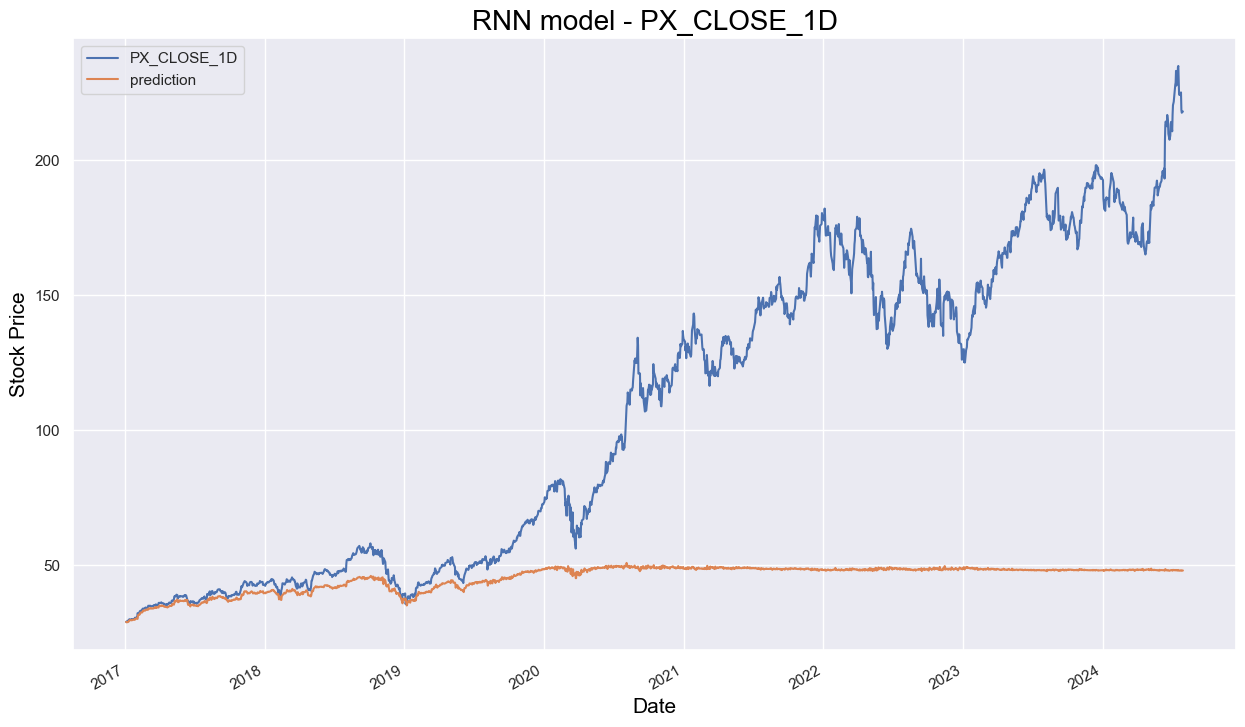

In [77]:
def actual_pred_plot(preds, data):
    '''
    Plot the actual vs. predicted prices

    :param preds: array of actual and predicted prices

    :returns: MSE score and plot of actual vs predicted prices
    '''
    # Create DataFrame containing actual and predicted prices
    actual_pred = pd.DataFrame(columns=['PX_CLOSE_1D', 'prediction'])
    actual_pred['PX_CLOSE_1D'] = data.loc['2017':, 'PX_CLOSE_1D'][0:len(preds)]
    actual_pred['prediction'] = preds[:, 0]

    # Calculate mean squared error
    m = tf.keras.metrics.MeanSquaredError()
    m.update_state(np.array(actual_pred['PX_CLOSE_1D']), np.array(actual_pred['prediction']))
    print("MSE score:", m.result().numpy())

    # Plot actual vs predicted price
    sns.set(rc={'figure.figsize': (15, 9)})
    actual_pred.plot()
    plt.title(f"{title_txt}", color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price', color='black', fontsize=15)
    plt.legend()
    plt.show()

title_txt = 'RNN model - PX_CLOSE_1D'

actual_pred_plot(rnn_predictions, data)

In [72]:
#next code for LSTM
print("next code for LSTM")

next code for LSTM


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MSE score: 3346.629


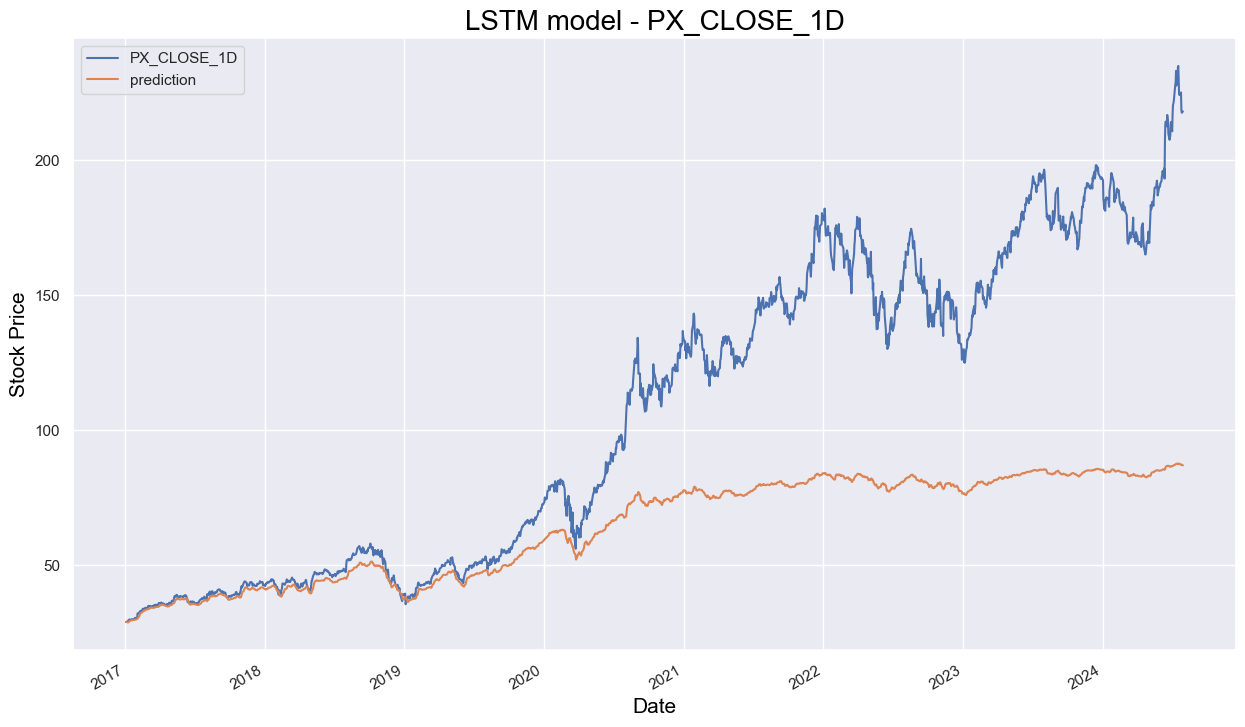

In [79]:
# Define the LSTM model
def LSTM_model(X_train, y_train, X_test, sc):
    """
    Create LSTM model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    """
    # The LSTM architecture
    my_LSTM_model = Sequential()
    # First LSTM layer
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    # Second LSTM layer
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # Dropout regularisation
    my_LSTM_model.add(Dropout(0.2))
    # The output layer
    my_LSTM_model.add(Dense(units=2))

    # Compile the LSTM model
    my_LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the LSTM model
    my_LSTM_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)

    # Make Predictions using the test set
    LSTM_predictions = my_LSTM_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    LSTM_predictions = sc.inverse_transform(LSTM_predictions)

    return my_LSTM_model, LSTM_predictions

# Train the LSTM model and make predictions
my_LSTM_model, LSTM_predictions = LSTM_model(X_train, y_train, X_test, sc)

# Plot actual vs. predicted prices for LSTM model
title_txt = 'LSTM model - PX_CLOSE_1D'
actual_pred_plot(LSTM_predictions, data)


In [59]:
print("next cod for gated recurrent")

next cod for gated recurrent


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MSE score: 2684.4302


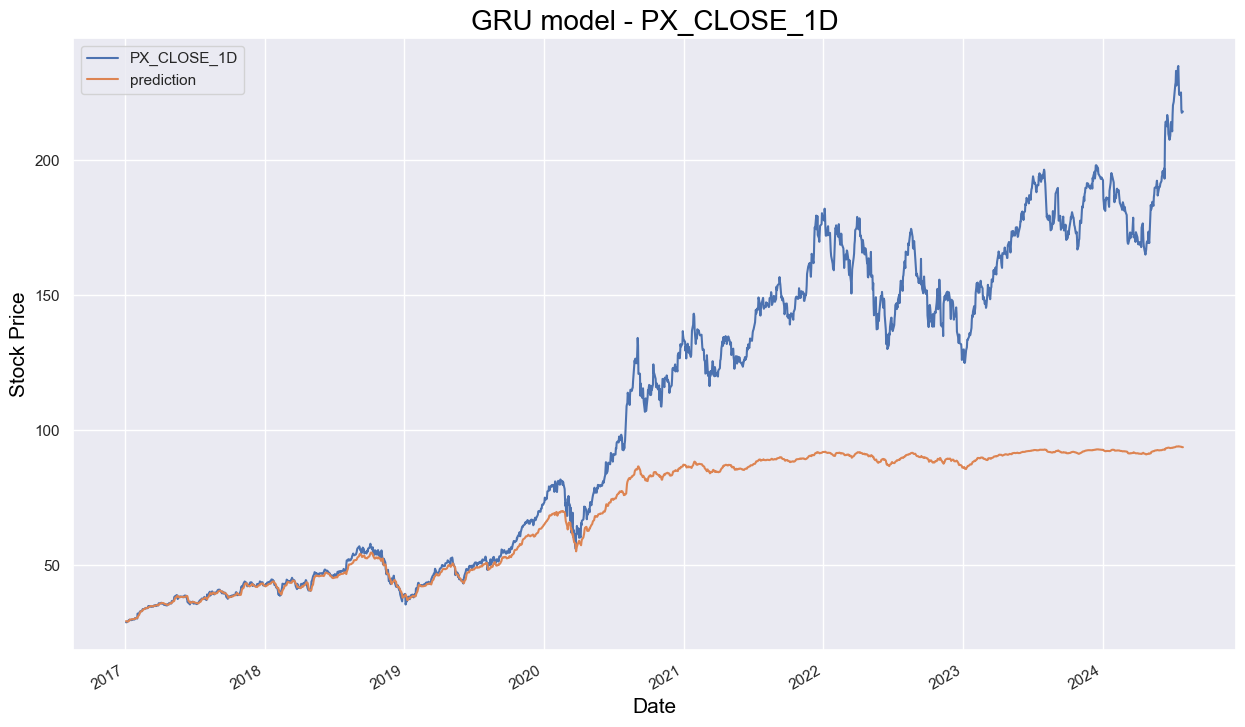

In [83]:
def GRU_model(X_train, y_train, X_test, sc):
    '''
    Create GRU model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns: trained model and array of predicted prices to original scale
    '''
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Third GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # The output layer
    my_GRU_model.add(Dense(units=2))

    # Compile the GRU model
    my_GRU_model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the GRU model
    my_GRU_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)

    # Make Predictions using the test set
    GRU_predictions = my_GRU_model.predict(X_test)
    # Apply the MinMaxScaler to convert the scaled predictions to the original scale
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

# Train the GRU model and make predictions
my_GRU_model, GRU_predictions = GRU_model(X_train, y_train, X_test, sc)

# Plot actual vs. predicted prices for GRU model
title_txt = 'GRU model - PX_CLOSE_1D'
actual_pred_plot(GRU_predictions, data)
